# NYC Taxi Fare Prediction

## Setup

In [558]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from geopy import distance
import folium
from string import ascii_uppercase

## Inspection

In [559]:
taxi = pd.read_csv('train_prev.csv')        # Truncated preview
taxi.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [560]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [561]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


## Cleaning

### Pickup Datetime

In [562]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'], infer_datetime_format=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


### NaN Values

In [563]:
taxi.dropna(subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


### Fare Amount

<Axes: xlabel='fare_amount'>

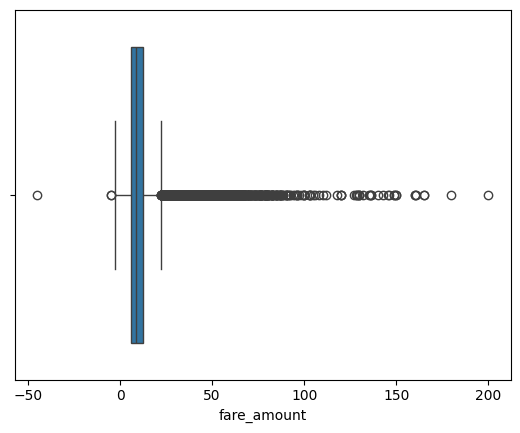

In [564]:
sns.boxplot(data=taxi, x='fare_amount')

In [565]:
# len(taxi.loc[~taxi['fare_amount'].between(0, 200)])
taxi = taxi.loc[taxi['fare_amount'].between(0, 200)]
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99951 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                99951 non-null  object             
 1   fare_amount        99951 non-null  float64            
 2   pickup_datetime    99951 non-null  datetime64[ns, UTC]
 3   pickup_longitude   99951 non-null  float64            
 4   pickup_latitude    99951 non-null  float64            
 5   dropoff_longitude  99951 non-null  float64            
 6   dropoff_latitude   99951 non-null  float64            
 7   passenger_count    99951 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.9+ MB


### Pickup Longitude

<Axes: xlabel='pickup_longitude'>

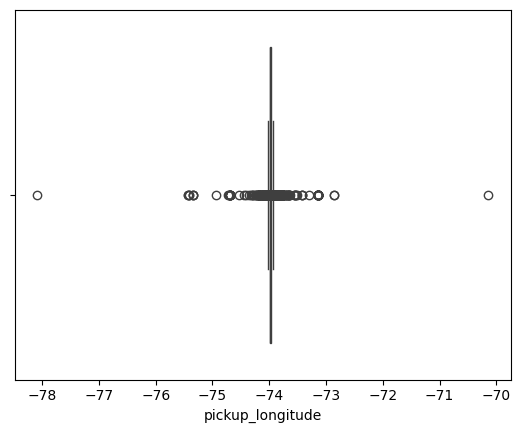

In [566]:
sns.boxplot(data=taxi.loc[taxi['pickup_longitude'].between(-80, -70)], x='pickup_longitude')

In [567]:
# len(taxi.loc[~taxi['pickup_longitude'].between(-74.5, -73.2)])
taxi = taxi.loc[taxi['pickup_longitude'].between(-74.5, -73.2)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97906.000000,97906.000000,97906.000000,97906.000000,97906.000000,97906.000000
mean,11.294870,-73.975364,40.754048,-73.910329,40.724663,1.674535
std,9.363955,0.035165,1.168619,2.169662,1.610089,1.300662
min,0.000000,-74.438233,0.783332,-84.654241,-2.269701,0.000000
25%,6.000000,-73.992265,40.736647,-73.991385,40.735685,1.000000
50%,8.500000,-73.982077,40.753523,-73.980425,40.753932,1.000000
75%,12.500000,-73.968323,40.767648,-73.965080,40.768452,2.000000
max,100.000000,-73.307595,401.083332,0.000000,404.616667,6.000000


### Pickup Latitude

<Axes: xlabel='pickup_latitude'>

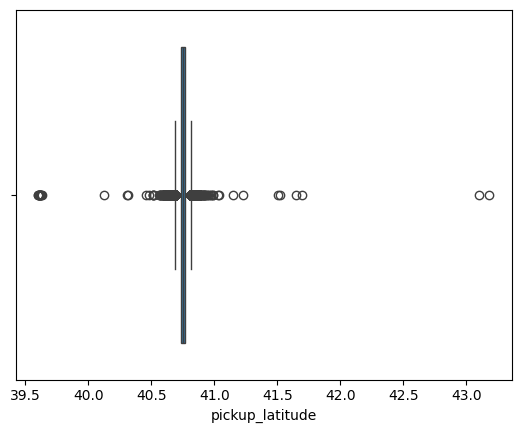

In [568]:
sns.boxplot(data=taxi.loc[taxi['pickup_latitude'].between(30, 50)], x='pickup_latitude')

In [569]:
# len(taxi.loc[~taxi['pickup_latitude'].between(40, 41.5)])
taxi = taxi.loc[taxi['pickup_latitude'].between(40, 41.5)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000,97883.000000
mean,11.295526,-73.975362,40.750926,-73.910321,40.724649,1.674591
std,9.364759,0.035122,0.027308,2.169915,1.610232,1.300662
min,0.000000,-74.438233,40.121653,-84.654241,-2.269701,0.000000
25%,6.000000,-73.992265,40.736655,-73.991385,40.735684,1.000000
50%,8.500000,-73.982079,40.753524,-73.980426,40.753932,1.000000
75%,12.500000,-73.968326,40.767648,-73.965088,40.768449,2.000000
max,100.000000,-73.307595,41.224752,0.000000,404.616667,6.000000


### Dropoff Longitude

<Axes: xlabel='dropoff_longitude'>

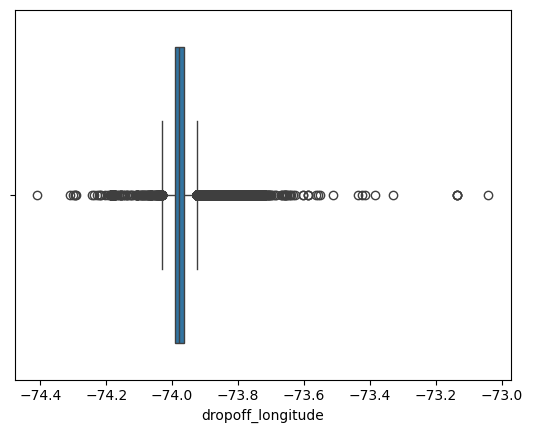

In [570]:
sns.boxplot(data=taxi.loc[taxi['dropoff_longitude'].between(-80, -70)], x='dropoff_longitude')

In [571]:
# len(taxi.loc[~taxi['dropoff_longitude'].between(-74.5, -73.2)])
taxi = taxi.loc[taxi['dropoff_longitude'].between(-74.5, -73.2)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97792.000000,97792.000000,97792.000000,97792.000000,97792.000000,97792.000000
mean,11.294534,-73.975370,40.750932,-73.974197,40.754641,1.674575
std,9.359129,0.035105,0.027302,0.034984,1.171020,1.300515
min,0.000000,-74.438233,40.121653,-74.408554,0.728087,0.000000
25%,6.000000,-73.992265,40.736656,-73.991393,40.735762,1.000000
50%,8.500000,-73.982084,40.753524,-73.980440,40.753954,1.000000
75%,12.500000,-73.968330,40.767652,-73.965158,40.768463,2.000000
max,100.000000,-73.307595,41.224752,-73.329048,404.616667,6.000000


### Dropoff Latitude

<Axes: xlabel='dropoff_latitude'>

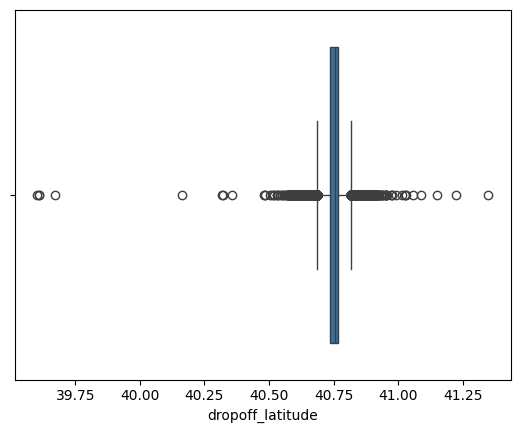

In [572]:
sns.boxplot(data=taxi.loc[taxi['dropoff_latitude'].between(30, 50)], x='dropoff_latitude')

In [573]:
# len(taxi.loc[~taxi['dropoff_latitude'].between(40, 41.5)])
taxi = taxi.loc[taxi['dropoff_latitude'].between(40, 41.5)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97786.000000,97786.000000,97786.000000,97786.000000,97786.000000,97786.000000
mean,11.294378,-73.975369,40.750933,-73.974197,40.751375,1.674585
std,9.359150,0.035105,0.027302,0.034985,0.031307,1.300540
min,0.000000,-74.438233,40.121653,-74.408554,40.164927,0.000000
25%,6.000000,-73.992265,40.736658,-73.991394,40.735765,1.000000
50%,8.500000,-73.982082,40.753524,-73.980441,40.753956,1.000000
75%,12.500000,-73.968329,40.767654,-73.965157,40.768463,2.000000
max,100.000000,-73.307595,41.224752,-73.329048,41.349023,6.000000


### Passenger Count

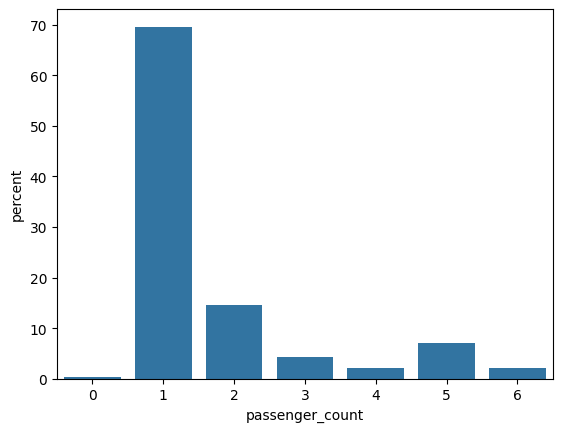

In [574]:
passenger_plt = sns.countplot(data=taxi, x='passenger_count', stat='percent')

In [575]:
# len(taxi.loc[taxi['passenger_count'] == 0])
taxi = taxi.loc[taxi['passenger_count'] != 0]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97428.000000,97428.000000,97428.000000,97428.000000,97428.000000,97428.000000
mean,11.302189,-73.975361,40.750930,-73.974200,40.751376,1.680739
std,9.368293,0.035121,0.027301,0.034980,0.031295,1.298952
min,0.000000,-74.438233,40.121653,-74.408554,40.164927,1.000000
25%,6.000000,-73.992265,40.736662,-73.991392,40.735771,1.000000
50%,8.500000,-73.982081,40.753524,-73.980441,40.753957,1.000000
75%,12.500000,-73.968324,40.767652,-73.965163,40.768452,2.000000
max,100.000000,-73.307595,41.224752,-73.329048,41.349023,6.000000


###

In [576]:
taxi.reset_index(drop=True, inplace=True)

In [577]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97428.000000,97428.000000,97428.000000,97428.000000,97428.000000,97428.000000
mean,11.302189,-73.975361,40.750930,-73.974200,40.751376,1.680739
std,9.368293,0.035121,0.027301,0.034980,0.031295,1.298952
min,0.000000,-74.438233,40.121653,-74.408554,40.164927,1.000000
25%,6.000000,-73.992265,40.736662,-73.991392,40.735771,1.000000
50%,8.500000,-73.982081,40.753524,-73.980441,40.753957,1.000000
75%,12.500000,-73.968324,40.767652,-73.965163,40.768452,2.000000
max,100.000000,-73.307595,41.224752,-73.329048,41.349023,6.000000


In [578]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97428 entries, 0 to 97427
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                97428 non-null  object             
 1   fare_amount        97428 non-null  float64            
 2   pickup_datetime    97428 non-null  datetime64[ns, UTC]
 3   pickup_longitude   97428 non-null  float64            
 4   pickup_latitude    97428 non-null  float64            
 5   dropoff_longitude  97428 non-null  float64            
 6   dropoff_latitude   97428 non-null  float64            
 7   passenger_count    97428 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 5.9+ MB


## Feature Engineering

### Distance

In [579]:
taxi['distance_km'] = taxi.apply(lambda r:distance.distance((r['pickup_latitude'], r['pickup_longitude']),(r['dropoff_latitude'], r['dropoff_longitude'])).km, axis=1)

In [580]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.029601
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.443441
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.795790
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338


### Time

In [581]:
taxi['pickup_hr'] = taxi.apply(lambda r: r['pickup_datetime'].hour, axis=1)
taxi['pickup_dayofweek'] = taxi.apply(lambda r: r['pickup_datetime'].dayofweek, axis=1)
taxi['pickup_dayofweek'].replace({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun', }, inplace=True)
taxi['pickup_month'] = taxi.apply(lambda r: r['pickup_datetime'].month, axis=1)
taxi['pickup_year'] = taxi.apply(lambda r: r['pickup_datetime'].year, axis=1)

taxi['pickup_nighttime'] = taxi.apply(lambda r: r['pickup_hr'] in [20, 21, 22, 23, 0, 1, 2, 3, 4, 5], axis=1)

In [582]:
taxi.tail(20)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hr,pickup_dayofweek,pickup_month,pickup_year,pickup_nighttime
97408,2010-06-27 22:21:25.0000003,6.9,2010-06-27 22:21:25+00:00,-73.985788,40.755992,-73.986090,40.756091,1,0.027771,22,Sun,6,2010,True
97409,2011-03-21 15:05:00.000000136,14.1,2011-03-21 15:05:00+00:00,-73.984670,40.761037,-74.016033,40.714663,2,5.791223,15,Mon,3,2011,False
97410,2011-07-30 18:10:00.000000139,16.9,2011-07-30 18:10:00+00:00,-73.955607,40.782738,-74.009868,40.746623,2,6.088862,18,Sat,7,2011,False
97411,2009-05-19 22:47:00.00000099,4.5,2009-05-19 22:47:00+00:00,-73.968073,40.761478,-73.973773,40.756237,2,0.755247,22,Tue,5,2009,True
97412,2010-06-03 08:27:00.000000184,8.9,2010-06-03 08:27:00+00:00,-73.982137,40.775522,-73.972260,40.759723,1,1.942570,8,Thu,6,2010,False
97413,2013-05-31 23:05:48.0000001,13.0,2013-05-31 23:05:48+00:00,-73.988230,40.779344,-73.984451,40.745273,1,3.796992,23,Fri,5,2013,True
97414,2009-06-27 00:47:00.00000058,4.9,2009-06-27 00:47:00+00:00,-73.980930,40.729518,-73.986248,40.738617,1,1.105792,0,Sat,6,2009,True
97415,2015-06-19 11:29:31.0000004,6.0,2015-06-19 11:29:31+00:00,-73.946312,40.777363,-73.955620,40.764187,1,1.660852,11,Fri,6,2015,False
97416,2011-03-05 10:01:58.0000004,11.7,2011-03-05 10:01:58+00:00,-73.990850,40.751173,-73.955861,40.776090,3,4.047747,10,Sat,3,2011,False
97417,2012-01-30 01:40:00.0000008,5.3,2012-01-30 01:40:00+00:00,-73.992065,40.759142,-73.979150,40.762897,1,1.167526,1,Mon,1,2012,True


### Passengers

In [583]:
taxi['multiple_passengers'] = np.where(taxi['passenger_count'] > 1, True, False)

### Location

In [584]:
clust_name_dict = {i:f'cluster_{c}' for i,c in enumerate(ascii_uppercase)}

pickup_locs = taxi[['pickup_longitude', 'pickup_latitude']]

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(pickup_locs)

taxi['pickup_loc'] = pd.Series(kmeans.labels_).replace(clust_name_dict)

In [585]:
dropoff_locs = taxi[['dropoff_longitude', 'dropoff_latitude']]

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(dropoff_locs)

taxi['dropoff_loc'] = pd.Series(kmeans.labels_).replace(clust_name_dict)

In [586]:
distance_locs = taxi[['distance_km', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(distance_locs)

taxi['distance_loc'] = pd.Series(kmeans.labels_).replace(clust_name_dict)

### Airports

In [587]:
taxi['jfk'] = (taxi['pickup_longitude'].between(-73.7841, -73.7721) & taxi['pickup_latitude'].between(40.6213, 40.6613)) | (taxi['dropoff_longitude'].between(-73.7841, -73.7721) & taxi['dropoff_latitude'].between(40.6213, 40.6613))
taxi['lga'] = (taxi['pickup_longitude'].between(-73.8870, -73.8580) & taxi['pickup_latitude'].between(40.7680, 40.7800)) | (taxi['dropoff_longitude'].between(-73.8870, -73.8580) & taxi['dropoff_latitude'].between(40.7680, 40.7800))
taxi['ewr'] = (taxi['pickup_longitude'].between(-74.1920, -74.1720) & taxi['pickup_latitude'].between(40.6760, 40.7080)) | (taxi['dropoff_longitude'].between(-74.1920, -74.1720) & taxi['dropoff_latitude'].between(40.6760, 40.7080))

print(taxi['fare_amount'].mean())
print(taxi.loc[taxi['jfk']]['fare_amount'].mean())
print(taxi.loc[taxi['lga']]['fare_amount'].mean())
print(taxi.loc[taxi['ewr']]['fare_amount'].mean())

11.302189206388306
45.44148148148148
30.532247084777815
68.27109374999999


In [588]:
# taxi['jfk_pu'] = taxi['pickup_longitude'].between(-73.7841, -73.7721) & taxi['pickup_latitude'].between(40.6213, 40.6613)
# taxi['jfk_do'] = taxi['dropoff_longitude'].between(-73.7841, -73.7721) & taxi['dropoff_latitude'].between(40.6213, 40.6613)

# taxi['lga_pu'] = taxi['pickup_longitude'].between(-73.8870, -73.8580) & taxi['pickup_latitude'].between(40.7680, 40.7800)
# taxi['lga_do'] = taxi['dropoff_longitude'].between(-73.8870, -73.8580) & taxi['dropoff_latitude'].between(40.7680, 40.7800)

# taxi['ewr_pu'] = taxi['pickup_longitude'].between(-74.1920, -74.1720) & taxi['pickup_latitude'].between(40.6760, 40.7080)
# taxi['ewr_do'] = taxi['dropoff_longitude'].between(-74.1920, -74.1720) & taxi['dropoff_latitude'].between(40.6760, 40.7080)

# print(taxi.loc[taxi['jfk_pu']]['fare_amount'].mean())
# print(taxi.loc[taxi['jfk_do']]['fare_amount'].mean())
# print(taxi.loc[taxi['lga_pu']]['fare_amount'].mean())
# print(taxi.loc[taxi['lga_do']]['fare_amount'].mean())
# print(taxi.loc[taxi['ewr_pu']]['fare_amount'].mean())
# print(taxi.loc[taxi['ewr_do']]['fare_amount'].mean())

In [589]:
m = folium.Map(location=(40.7, -74.0))
folium.Marker(location=(40.642, -73.779), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
folium.Marker(location=(40.776, -73.874), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
folium.Marker(location=(40.691, -74.178), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
# taxi.loc[taxi['jfk_pu']].apply(lambda r:folium.Marker(location=(r['pickup_latitude'], r['pickup_longitude'])).add_to(m), axis=1)

display(m)

## Relationships

### Fare vs Distance

<Axes: xlabel='distance_km', ylabel='fare_amount'>

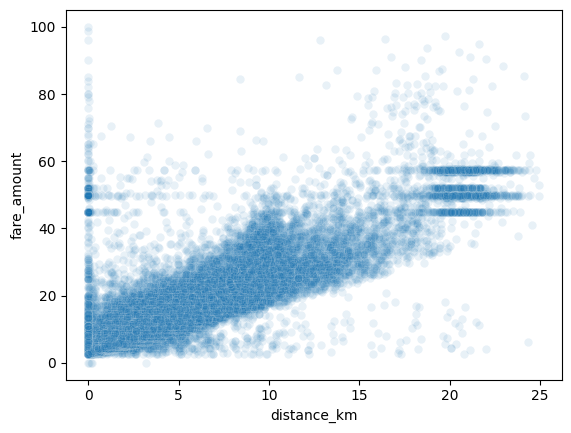

In [590]:
sns.scatterplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', alpha=0.1)

In [591]:
# sns.lmplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='passenger_count', scatter_kws={'alpha':0.1})

### Fare vs Passengers

<Axes: xlabel='passenger_count', ylabel='count'>

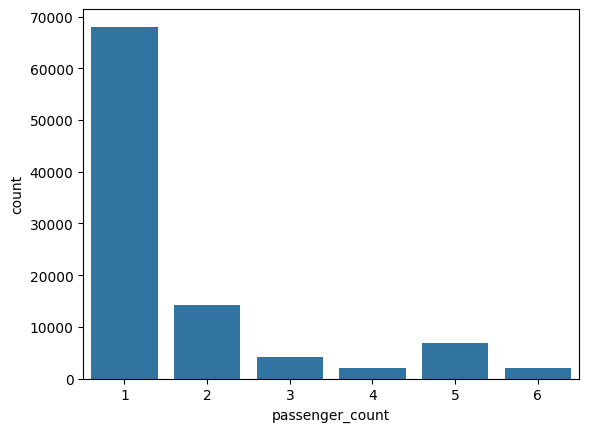

In [592]:
sns.countplot(data=taxi, x='passenger_count')

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

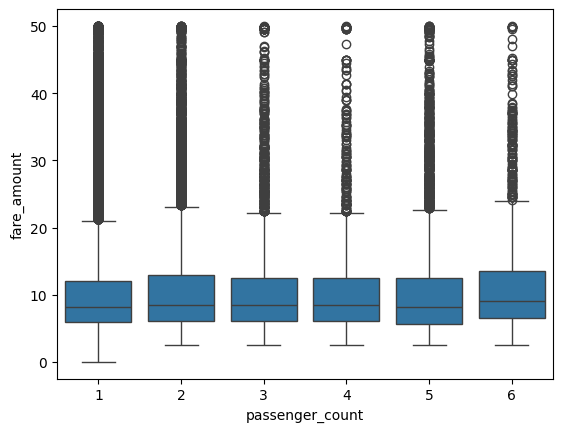

In [593]:
sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='passenger_count', y='fare_amount')

<Axes: xlabel='multiple_passengers', ylabel='fare_amount'>

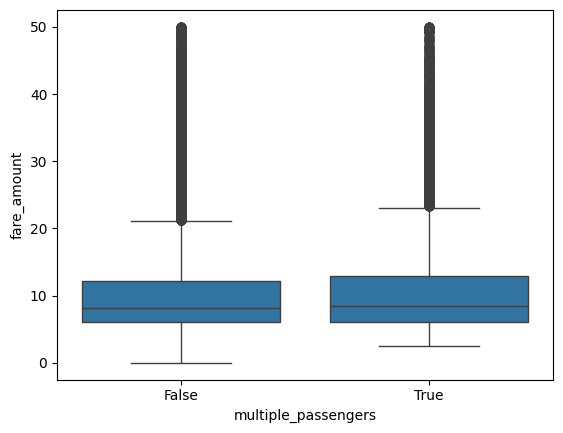

In [594]:
taxi_pass_red = taxi.copy()
taxi_pass_red['multiple_passengers'] = np.where(taxi_pass_red['passenger_count'] > 1, True, False)

sns.boxplot(data=taxi_pass_red.loc[taxi_pass_red['fare_amount'] <= 50], x='multiple_passengers', y='fare_amount')

In [595]:
# sns.lmplot(data=taxi_pass_red.loc[taxi_pass_red['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='multiple_passengers', scatter_kws={'alpha':0.02})

### Fare vs Time

#### Fare vs Pickup Hour

Text(0.5, 1.0, 'Fare vs Pickup Hour')

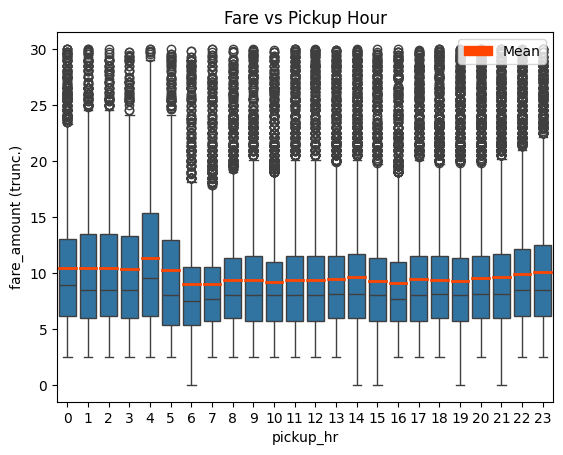

In [596]:
fare_hr_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_hr', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_hr_box.set_ylabel(f'{fare_hr_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Hour')

#### Fare vs Pickup Day of Week

Text(0.5, 1.0, 'Fare vs Pickup Day of Week')

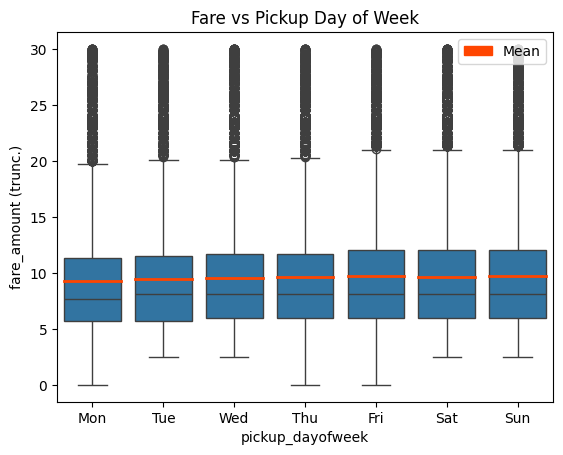

In [597]:
fare_dayofweek_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_dayofweek', y='fare_amount', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_dayofweek_box.set_ylabel(f'{fare_dayofweek_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Day of Week')

#### Fare vs Pickup Month

Text(0.5, 1.0, 'Fare vs Pickup Month')

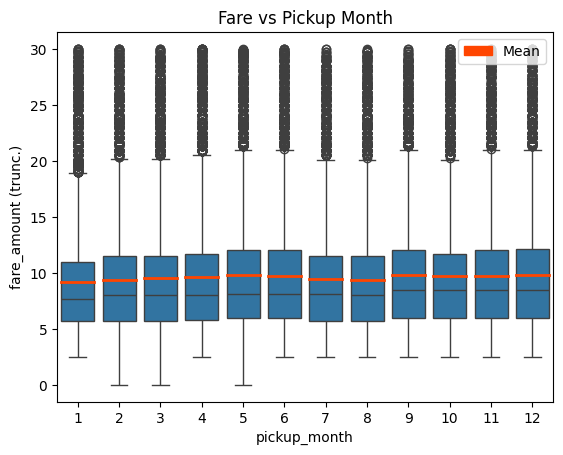

In [598]:
fare_month_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_month', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_month_box.set_ylabel(f'{fare_month_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Month')

#### Fare vs Pickup Year

Text(0.5, 1.0, 'Fare vs Pickup Year')

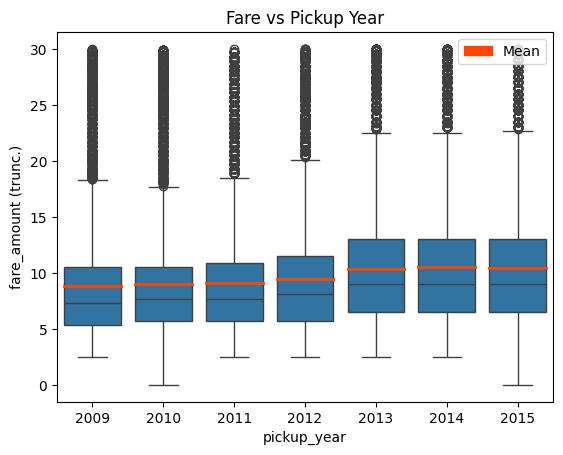

In [599]:
fare_year_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_year', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_year_box.set_ylabel(f'{fare_year_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Year')

#### Fare vs Pickup Day of Week and Hour

<Axes: xlabel='pickup_dayofweek', ylabel='pickup_hr'>

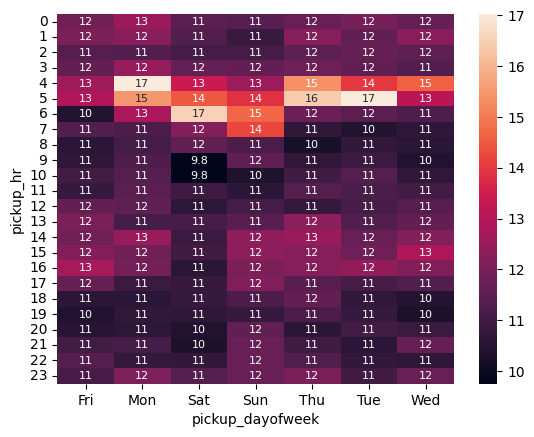

In [600]:
fare_dayofweek_hr = taxi.groupby(['pickup_dayofweek', 'pickup_hr'])['fare_amount'].mean().reset_index()
fare_dayofweek_hr = fare_dayofweek_hr.pivot(index='pickup_hr', columns='pickup_dayofweek', values='fare_amount')

sns.heatmap(data=fare_dayofweek_hr, annot=True, annot_kws={'size':8})

### Location

In [601]:
# sns.scatterplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='pickup_longitude', y='pickup_latitude', hue='fare_amount', alpha=0.5)

In [602]:
# sns.scatterplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='dropoff_longitude', y='dropoff_latitude', hue='fare_amount', alpha=0.5)

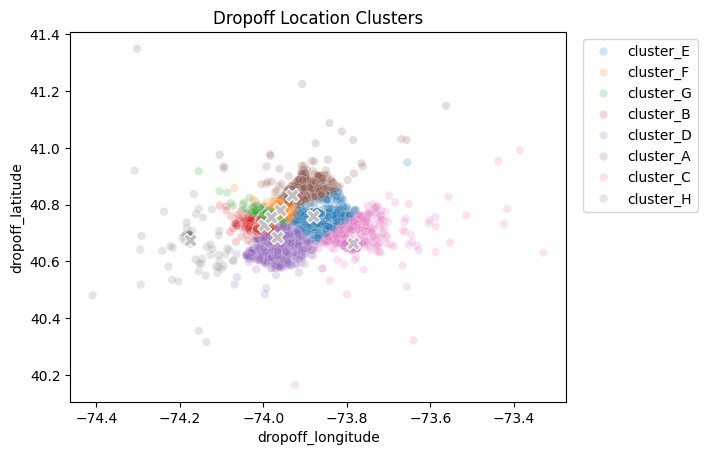

In [603]:
dropoff_locs = taxi[['dropoff_longitude', 'dropoff_latitude']]
# scaler = StandardScaler()
# scaled_dropoff_locs = scaler.fit_transform(dropoff_locs)

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(dropoff_locs)

clust_name_dict = {i:f'cluster_{c}' for i,c in enumerate(ascii_uppercase)}
kmeans_clusters = pd.Series(kmeans.labels_).replace(clust_name_dict)
kmeans_centroids = pd.DataFrame(kmeans.cluster_centers_).rename(columns={0:'dropoff_longitude', 1:'dropoff_latitude'}, index=clust_name_dict)

sns.scatterplot(data=taxi, x='dropoff_longitude', y='dropoff_latitude', hue=kmeans_clusters, alpha=0.2)
sns.scatterplot(data=kmeans_centroids, x='dropoff_longitude', y='dropoff_latitude', s=100, c='silver', marker='X')
plt.title('Dropoff Location Clusters')
plt.legend(loc='upper right', bbox_to_anchor=(1.28, 1))

In [604]:
kmeans_cluster_fares = pd.DataFrame()
kmeans_cluster_fares['count'] = taxi.groupby(kmeans_clusters)['key'].count()
kmeans_cluster_fares['mean'] = taxi.groupby(kmeans_clusters)['fare_amount'].mean()
kmeans_cluster_fares['mean_diff'] = kmeans_cluster_fares['mean'] - taxi['fare_amount'].mean()
kmeans_cluster_fares['summed_diff'] = kmeans_cluster_fares['count'] * abs(kmeans_cluster_fares['mean_diff'])
print(kmeans_cluster_fares['summed_diff'].sum()/len(taxi))
kmeans_cluster_fares.head(100)

# ax = sns.barplot(kmeans_cluster_fares)
# ax.bar_label(ax.containers[0], fontsize=6)

2.6581063310416404


,count,mean,mean_diff,summed_diff
cluster_A,2082,19.378405,8.076216,16814.682072
cluster_B,25588,10.063533,-1.238656,31694.737413
cluster_C,1186,40.128769,28.826580,34188.323601
cluster_D,4509,18.559275,7.257086,32722.198868
cluster_E,3071,23.421687,12.119498,37218.976947
cluster_F,21436,9.706864,-1.595325,34197.387828
cluster_G,39378,9.687205,-1.614985,63594.866569
cluster_H,178,59.295506,47.993316,8542.810321


In [605]:
# optics_model = OPTICS(min_cluster_size=0.01)
# optics_model.fit(taxi[['dropoff_longitude', 'dropoff_latitude']])

# optics_clusters = pd.Series(optics_model.labels_).replace(clust_name_dict)
# optics_clusters.head(20)

# sns.scatterplot(data=taxi, x='dropoff_longitude', y='dropoff_latitude', hue=optics_clusters, alpha=0.3)

In [606]:
# optics_cluster_fares = pd.DataFrame()
# optics_cluster_fares['count'] = taxi.groupby(optics_clusters)['key'].count()
# optics_cluster_fares['mean'] = taxi.groupby(optics_clusters)['fare_amount'].mean()
# optics_cluster_fares['mean_diff'] = optics_cluster_fares['mean'] - taxi['fare_amount'].mean()
# optics_cluster_fares['summed_diff'] = optics_cluster_fares['count'] * abs(optics_cluster_fares['mean_diff'])
# print(optics_cluster_fares['summed_diff'].sum()/len(taxi))
# optics_cluster_fares.head(100)

## Data Selection

In [607]:
y = taxi['fare_amount']

features = ['distance_km', 'pickup_nighttime', 'jfk', 'lga', 'ewr']
ohe_features = ['pickup_year', 'pickup_loc', 'dropoff_loc', 'distance_loc']

features_list = features + ohe_features

X_incl_cat = taxi[features_list]
X = pd.get_dummies(X_incl_cat, columns=ohe_features)

# print(X.columns)


## Modelling

In [608]:
test_size_vals = [0.1, 0.2, 0.4]
results_dict = {}

repeats = 10
aggr_RMSE_list = [0 for _ in range(repeats)]

# model = LinearRegression()
# model = RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1)
model = HistGradientBoostingRegressor(categorical_features=[f for f in X if f.startswith(tuple(ohe_features))])
for test_size_val in test_size_vals:
    for repeat in range(repeats):
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=test_size_val, random_state=repeat)
        model.fit(train_X, train_y)
        pred_y = model.predict(val_X)
        aggr_RMSE_list[repeat] = mean_squared_error(val_y, pred_y, squared=False)
    aggr_RMSE = (sum(aggr_RMSE_list)/repeats)
    results_dict[test_size_val] = round(aggr_RMSE, 4)

results = pd.Series(results_dict)
print(f"Mean RMSE: {results.mean():.4f}")
print(results)

Mean RMSE: 3.7954
0.1    3.7750
0.2    3.7810
0.4    3.8302
dtype: float64


In [609]:
# train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1)

# linreg = LinearRegression()
# linreg.fit(train_X, train_y)

# pred_y = linreg.predict(val_X)
# RMSE = mean_squared_error(val_y, pred_y, squared=False)

# print(f'Linear Regression model with coefficients: {linreg.coef_.round(4)}, and intercept: {round(linreg.intercept_, 4)}')
# print(f'RMSE: {round(RMSE, 4)}')